<br/>

## <div style="padding:10px;background-color:#9d5a47;margin:10;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 1px 10px;overflow:hidden;font-weight:50;width:auto">Sony Churn Project - Modeling</div>

In [2]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')



In [3]:
df = pd.read_parquet(data_path / 'Data_Science_Challenge - prepped.parquet')
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## First modeling pass - no balance correction

In [9]:
# train test split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn'])
y = df['churn']

train_ds = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_ds

In [12]:
for x in train_ds:
    print(x.shape)

(2666, 18)
(667, 18)
(2666,)
(667,)


20% test creates a decent shape - enough samples in the test set to see if we're good and enough in the train set to let many models learn

We have created a train set and a validation set.  I would ideally also create a holdout set, but the number of samples is already low.  In a real dataset of this type, there would be vastly more samples.


### Random Forest Classification

remember - imbalanced


              precision    recall  f1-score   support

       False       0.95      0.99      0.97       566
        True       0.95      0.68      0.79       101

    accuracy                           0.95       667
   macro avg       0.95      0.84      0.88       667
weighted avg       0.95      0.95      0.94       667



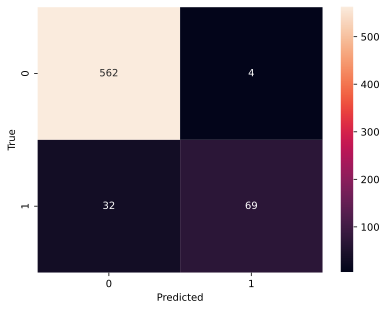

In [20]:

from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(
    n_estimators=45, criterion='entropy', n_jobs=-1).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predicted')

print(classification_report(y_test, y_pred))


## Logistic Regression Model - imbalanced

LR is much more prone to balance effects. Also multi-collinearity. 


              precision    recall  f1-score   support

       False       0.87      0.98      0.92       566
        True       0.58      0.18      0.27       101

    accuracy                           0.86       667
   macro avg       0.73      0.58      0.60       667
weighted avg       0.83      0.86      0.82       667



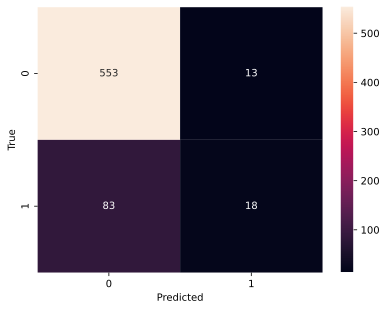

In [19]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = lr.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predicted')

print(classification_report(y_test, y_pred))